In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler

import PIL
import pandas as pd
from tqdm.notebook import tqdm
import json
import time
import cv2
import random
import glob
import os
import copy
from sklearn.metrics import r2_score

In [2]:
x = np.loadtxt('/Volumes/GoogleDrive/My Drive/Skoltech/Research/Hydrogen Oxidation/input_197.txt', delimiter= ' ')
#drop inert gases
x = np.delete(x, [8,9], 1)
x[:, np.newaxis, :].shape

(197, 1, 10)

In [3]:
y = np.loadtxt('/Volumes/GoogleDrive/My Drive/Skoltech/Research/Hydrogen Oxidation/Out_files_197/out10.txt', delimiter= ';')
#drop times and inert gases & consider only first 100 timesteps
y = y[:,1:-2]
y.shape

(201, 9)

In [4]:
y[50,:]

array([2.69188e+03, 9.49394e+00, 4.08925e+00, 4.20713e+00, 1.91594e+00,
       1.66845e+00, 1.41277e+01, 1.31746e-03, 4.95959e-06])

In [5]:
y[[0, 50, 100, 150, 200], :]

array([[2.87400e+03, 1.29410e+01, 1.84185e+00, 3.14553e+00, 3.70200e+00,
        1.28248e+00, 1.19938e+01, 3.63092e-03, 2.37406e-03],
       [2.69188e+03, 9.49394e+00, 4.08925e+00, 4.20713e+00, 1.91594e+00,
        1.66845e+00, 1.41277e+01, 1.31746e-03, 4.95959e-06],
       [2.69188e+03, 9.49394e+00, 4.08925e+00, 4.20713e+00, 1.91594e+00,
        1.66845e+00, 1.41277e+01, 1.31746e-03, 4.95959e-06],
       [2.69188e+03, 9.49394e+00, 4.08925e+00, 4.20713e+00, 1.91594e+00,
        1.66845e+00, 1.41277e+01, 1.31746e-03, 4.95959e-06],
       [2.69188e+03, 9.49394e+00, 4.08925e+00, 4.20713e+00, 1.91594e+00,
        1.66845e+00, 1.41277e+01, 1.31746e-03, 4.95959e-06]])

## Data Preprocessing:
Making a custom torch dataloader

In [6]:
class OxidationDataset(Dataset):

    def __init__(self, inputs_path, outputs_dir, ntimesteps):
        """
        Args:
            inputs_dir (string): 
            outputs_dir (string):
        """
        
        # x = np.loadtxt(inputs_path, skiprows = 1, delimiter= ',')
        x = np.loadtxt(inputs_path, delimiter= ' ')
        #drop inert gases
        self.inputs = np.delete(x, [8,9], 1)[:, np.newaxis]
        self.out_dir = outputs_dir
        self.ntimesteps = ntimesteps


    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        #get output
        Y = np.loadtxt(os.path.join(self.out_dir, f'out{idx}.txt'), delimiter= ';')
        # Y = np.loadtxt(f'{self.out_dir}/out{idx}.txt', delimiter = ';')
        
        #drop inert gases
        if type(self.ntimesteps) == int:
            Y = Y[:self.ntimesteps, 1:-2]
        elif type(self.ntimesteps) == list:
            Y = Y[self.ntimesteps, 1:-2]
        else:
            raise ValueError("input argument 'ntimestep should either be of type int or list'")
        # print(idx)
        return torch.from_numpy(self.inputs[idx]), torch.from_numpy(Y)

In [7]:
#for data standardization
def standardize(tensor, dim = 0, mean = None, std = None) -> torch.float64:
    tensor = tensor.float()
    
    if mean is None:
        mean = tensor.mean(dim = dim, keepdim = True)
    
    if std is None:
        std = tensor.std(dim = dim, keepdim = True)

    standard_tensor = (tensor - mean) / std
    return standard_tensor, mean, std

def inverse_standardize(tensor, dim, mean, std):
    tensor = tensor.float()
    return tensor * std + mean

## The network

In [8]:
class RNN_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN_Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(self.input_size, self.hidden_size, self.num_layers, dropout = 0.1, batch_first = True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.linear(out)
        return out
    
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_uniform_(m.weight, nonlinearity= 'relu')
        m.bias.data.fill_(0.0)

## The Inference

In [9]:
#initialize dataset object
batch_size = 32
ntimesteps = [-1]
dataset = OxidationDataset(inputs_path = '/Volumes/GoogleDrive/My Drive/Skoltech/Research/Hydrogen Oxidation/input_197.txt',
                           outputs_dir = '/Volumes/GoogleDrive/My Drive/Skoltech/Research/Hydrogen Oxidation/Out_files_197',
                           ntimesteps = ntimesteps)
# Creating Training and Validation loaders
dataset_size = len(dataset)
indices = list(range(dataset_size))
validation_split = 0.2
split = int(np.floor(validation_split * dataset_size))
shuffle_dataset = True
random_seed = 42
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

In [17]:
x,y = next(iter((train_loader))) #check number of features and targets
x.shape, y.shape

(torch.Size([32, 1, 10]), torch.Size([32, 1, 9]))

In [18]:
#obtaining mean and std of training set
train_x = []
train_y = []
for x,y in train_loader:
    train_x.append(x)
    train_y.append(y)

_, train_x_mean, train_x_std = standardize(torch.concat(train_x), 0)
_, train_y_mean, train_y_std = standardize(torch.concat(train_y), 0)

In [19]:
train_x_mean.shape

torch.Size([1, 1, 10])

In [69]:
#initialize the model
input_size = 10
hidden_size = 32
num_layers = 2
output_size = 9
model = RNN_Model(input_size, hidden_size, num_layers, output_size)
model.apply(init_weights)
model

RNN_Model(
  (rnn): RNN(10, 32, num_layers=2, batch_first=True, dropout=0.1)
  (linear): Linear(in_features=32, out_features=9, bias=True)
)

In [70]:
if torch.cuda.is_available():
    model = model.cuda()
    train_x_mean = train_x_mean.cuda()
    train_x_std = train_x_std.cuda()
    train_y_mean = train_y_mean.cuda()
    train_y_std = train_y_std.cuda()

In [71]:
%%time
 # Declaring Criterion and Optimizer
criterion = nn.MSELoss()
#lr changed from 0.1 t0 0.05 after 400 epochs #from 0.05 to 0.01 after next 100 epochs
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# Training with Validation
epochs = 1000
min_valid_loss = np.inf
train_loss = []
valid_loss = []

for e in range(epochs):
    train_loss_ = 0.0
    model.train()
    for input, output in train_loader:
        # Transfer Data to GPU if available
        if torch.cuda.is_available():
            input, output = input.cuda(), output.cuda()
            
        #standardize
        input, _, _ = standardize(input, 0, train_x_mean, train_x_std)
        output, _, _ = standardize(output, 0, train_y_mean, train_y_std)

        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        predict = model(input.float())
        # Find the Loss
        # print(predict.shape, output.shape)
        loss = criterion(predict,output.float())
        # Calculate gradients
        loss.backward()
        # Update Weights
        optimizer.step()
        # Calculate Loss
        train_loss_ += loss.item()
     
    valid_loss_ = 0.0
    model.eval()     # Optional when not using Model Specific layer
    for input, output in validation_loader:
        # Transfer Data to GPU if available
        if torch.cuda.is_available():
            input, output = input.cuda(), output.cuda()
        
        #standardize
        input, _, _ = standardize(input, 0, train_x_mean, train_x_std)
        output, _, _ = standardize(output, 0, train_y_mean, train_y_std)
         
        # Forward Pass
        predict = model(input.float())
        # Find the Loss
        loss = criterion(predict,output.float())
        # Calculate Loss
        valid_loss_ += loss.item()
    
    # scheduler.step()

    if (e+1)%50 == 0:
        print(f'Epoch {e+1} \t\t Training Loss: {train_loss_ / len(train_loader)} \t\t Validation Loss: {valid_loss_ / len(validation_loader)}')

    train_loss.append(train_loss_ / len(train_loader))
    valid_loss.append(valid_loss_ / len(validation_loader))
     
    if min_valid_loss > valid_loss_:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss_:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss_
         
        # Saving State Dict
        torch.save(model.state_dict(), '/Volumes/GoogleDrive/My Drive/Skoltech/Research/Hydrogen Oxidation/Models/rnn.pth')
    # Save final model
    if (e+1) == epochs:
        # Saving State Dict
        torch.save(model.state_dict(), '/Volumes/GoogleDrive/My Drive/Skoltech/Research/Hydrogen Oxidation/Models/rnn_final.pth')

Validation Loss Decreased(inf--->0.798462) 	 Saving The Model
Validation Loss Decreased(0.798462--->0.520278) 	 Saving The Model
Validation Loss Decreased(0.520278--->0.393363) 	 Saving The Model
Validation Loss Decreased(0.393363--->0.343306) 	 Saving The Model
Validation Loss Decreased(0.343306--->0.311877) 	 Saving The Model
Validation Loss Decreased(0.311877--->0.273701) 	 Saving The Model
Validation Loss Decreased(0.273701--->0.260156) 	 Saving The Model
Validation Loss Decreased(0.260156--->0.208900) 	 Saving The Model
Validation Loss Decreased(0.208900--->0.197140) 	 Saving The Model
Validation Loss Decreased(0.197140--->0.159943) 	 Saving The Model
Validation Loss Decreased(0.159943--->0.143043) 	 Saving The Model
Validation Loss Decreased(0.143043--->0.124325) 	 Saving The Model
Validation Loss Decreased(0.124325--->0.120637) 	 Saving The Model
Validation Loss Decreased(0.120637--->0.090544) 	 Saving The Model
Validation Loss Decreased(0.090544--->0.082469) 	 Saving The Model


Text(0, 0.5, 'MSE')

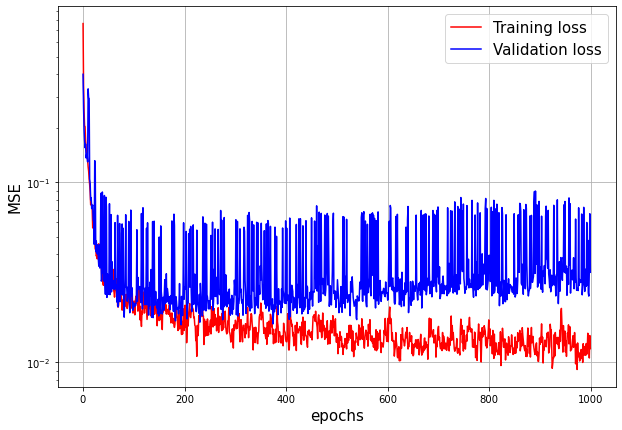

In [72]:
plt.figure(figsize = (10,7))
epochs = len(train_loss)
plt.plot(range(epochs),train_loss,'-r',label = 'Training loss')
plt.plot(range(epochs),valid_loss,'-b',label = 'Validation loss')
plt.yscale('log')
plt.legend(fontsize=15)
plt.grid()
plt.xlabel('epochs', fontsize=15)
plt.ylabel('MSE', fontsize=15)
# plt.title(f'Loss curve (2ks {len(dataset.guage_space)}sensor)', fontsize = 20)}

In [1006]:
# fcmodel_2x2CG_996sensors_losses = {'train_loss': train_loss, 'val_loss': valid_loss}
# a_file = open(f'/home/av_lab/Documents/My MSc Research/Results/Models/fcmodel_2x2CG_{len(dataset.guage_space)}sensors_1lr_64bs_losses.json', "w")
# json.dump(fcmodel_2x2CG_996sensors_losses, a_file)
# a_file.close()

In [191]:
# loss = json.load(open('/home/av_lab/Documents/My MSc Research/Results/Models/fcmodel_2x2CG_10sensors_1lr_64bs_losses.json', "r"))
# train_loss = loss['train_loss']
# valid_loss = loss['val_loss']
# plt.figure(figsize = (10,7))
# epochs = len(train_loss)
# plt.plot(range(epochs),train_loss,'-r',label = 'Training loss')
# plt.plot(range(epochs),valid_loss,'-b',label = 'Validation loss')
# plt.yscale('log')
# plt.legend(fontsize=15)
# plt.grid()
# plt.xlabel('epochs', fontsize=15)
# plt.ylabel('MSE', fontsize=15)
# # plt.title(f'Loss curve (2ks {len(dataset.guage_space)}sensor)', fontsize = 20)
# plt.savefig('/home/av_lab/Documents/My MSc Research/Results/Figs/fcmodel_2x2CG_10sensors_1lr_64bs_losses.pdf')

In [73]:
model.load_state_dict(torch.load('/Volumes/GoogleDrive/My Drive/Skoltech/Research/Hydrogen Oxidation/Models/rnn.pth',
                                 map_location=torch.device('cpu')))
if torch.cuda.is_available():
    model = model.cuda()

model.eval()

RNN_Model(
  (rnn): RNN(10, 32, num_layers=2, batch_first=True, dropout=0.1)
  (linear): Linear(in_features=32, out_features=9, bias=True)
)

In [145]:
##NME
output_stack = []
predict_stack = []
for i, (input, output) in enumerate(validation_loader):
  if torch.cuda.is_available():
      input, output = input.cuda(), output.cuda()

  #standardize
  input, _, _ = standardize(input, 0, train_x_mean, train_x_std)

  pred = model(input.float())
  predict_stack.append(inverse_standardize(pred, 0, train_y_mean, train_y_std))
  output_stack.append(output)

error = torch.linalg.norm(torch.concat(output_stack) - torch.concat(predict_stack))/torch.linalg.norm(torch.concat(output_stack))
print(f'Normalized Error: {error}')

Normalized Error: 0.0035095417681992197


In [146]:
torch.concat(predict_stack)[:, 0, 0]

tensor([2487.2239, 2740.0222, 2695.6125, 2626.1257, 2739.5745, 2720.3574,
        2727.7136, 2738.3416, 2578.0979, 2748.6091, 2631.9683, 2549.2520,
        2705.6702, 2543.0251, 2730.9460, 2732.2039, 2641.2102, 2600.5193,
        2771.9131, 2818.6877, 2546.2083, 2819.7964, 2751.4910, 2895.9680,
        2550.1921, 2577.1338, 2565.4893, 2617.9390, 2754.4355, 2690.7778,
        2656.5852, 2879.3713, 2531.1904, 2531.7690, 2828.7976, 2679.7424,
        2706.1729, 2721.9514, 2638.2942], grad_fn=<SelectBackward0>)

In [147]:
torch.concat(output_stack)[:, 0, 0]

tensor([2477.7300, 2740.7900, 2691.6800, 2621.3500, 2738.1200, 2712.2800,
        2722.5200, 2735.4800, 2594.2100, 2742.6600, 2636.6200, 2551.6900,
        2695.2800, 2554.1500, 2737.0100, 2728.7400, 2640.3100, 2605.1000,
        2775.0300, 2828.0900, 2563.8400, 2832.5800, 2744.2900, 2898.8900,
        2533.7300, 2566.5800, 2540.9300, 2625.7400, 2750.5500, 2683.9900,
        2646.6500, 2877.5700, 2534.7200, 2522.0900, 2845.9200, 2669.2100,
        2702.4300, 2711.4700, 2635.8100], dtype=torch.float64)

In [148]:
##NFE
target = torch.concat(output_stack) - torch.concat(predict_stack).mean(dim =0)
pred = torch.concat(predict_stack) - torch.concat(predict_stack).mean(dim =0)
error = torch.linalg.norm(target - pred)/torch.linalg.norm(target)
print(f'Normalized Error: {error}')

Normalized Error: 0.09071632913221682


In [149]:
r2_score(torch.concat(output_stack).flatten().detach().numpy(), torch.concat(predict_stack).flatten().detach().numpy())

0.9999861066149432

In [150]:
predict

tensor([[[ 1.2728, -0.8750, -0.4585,  0.5708,  0.4527, -0.1727, -0.8702,
          -0.4446, -0.5983]],

        [[-0.3861, -1.1018, -1.0428, -0.7231, -0.1573, -0.8541, -0.8935,
          -0.8567, -0.8218]],

        [[ 0.6327, -0.0187, -0.0111,  0.9489,  1.7147,  1.1174,  0.4214,
           1.0366,  0.9072]],

        [[ 0.8773, -0.4366, -0.1873,  0.6198,  0.6288,  0.2278, -0.4150,
          -0.0592, -0.2193]],

        [[-1.2241,  0.4699, -0.1936, -0.5961, -0.3430,  0.0110,  1.3809,
           0.0395,  0.3506]],

        [[ 0.1756,  0.0685, -0.0194,  0.3417,  0.4398,  0.5206,  0.4122,
           0.4123,  0.3536]],

        [[ 0.4755, -0.7289, -0.5644,  0.4285,  1.8436,  0.2896, -0.4486,
           0.0844, -0.0240]]], grad_fn=<AddBackward0>)

In [151]:
#visualization
def result_plot(y_test, pred):
    fig, ax = plt.subplots(3, 3, figsize=(20,15))
    title =  [ 'T', 'H2', 'H', 'O', 'O2', 'OH', 'H2O', 'HO2', 'H2O2']
    for i in range(9):
        a = i//3; b= i%3
        ax[a,b].scatter(pred[:,i], y_test[:,i])
        ax[a,b].plot(np.arange(y_test[:,i].min(), y_test[:,i].max()), 
                     np.arange(y_test[:,i].min(), y_test[:,i].max()), '--k')
        ax[a,b].set_title(title[i])
        ax[a,b].set_xlabel('Prediction')
        ax[a,b].set_ylabel('Groundtruth')
    plt.show()

In [152]:
torch.concat(output_stack).detach().squeeze()[:,-1]

tensor([7.2241e-06, 2.5977e-06, 4.2887e-06, 1.3264e-05, 1.7428e-05, 1.8738e-06,
        1.0328e-05, 7.3139e-07, 8.3956e-06, 1.6221e-06, 1.2348e-06, 1.4191e-05,
        1.3423e-05, 1.7672e-06, 1.4109e-06, 3.5716e-06, 4.7820e-07, 1.4531e-06,
        4.7713e-05, 7.0648e-06, 3.6340e-06, 2.5333e-06, 8.1072e-06, 5.9391e-06,
        2.0186e-06, 9.4066e-07, 4.0519e-07, 1.0951e-06, 5.0372e-06, 1.1289e-06,
        4.2764e-06, 1.1395e-05, 2.6993e-06, 1.1026e-05, 1.1446e-05, 8.4082e-06,
        7.0609e-06, 2.0235e-05, 2.3553e-06], dtype=torch.float64)

In [153]:
model.eval()
##NME
output_stack = []
predict_stack = []
for i, (input, output) in enumerate(validation_loader):
    if torch.cuda.is_available():
        input, output = input.cuda(), output.cuda()

    #standardize
    input, _, _ = standardize(input, 0, train_x_mean, train_x_std)

    pred = model(input.float())
    predict_stack.append(inverse_standardize(pred, 0, train_y_mean, train_y_std))
    output_stack.append(output)

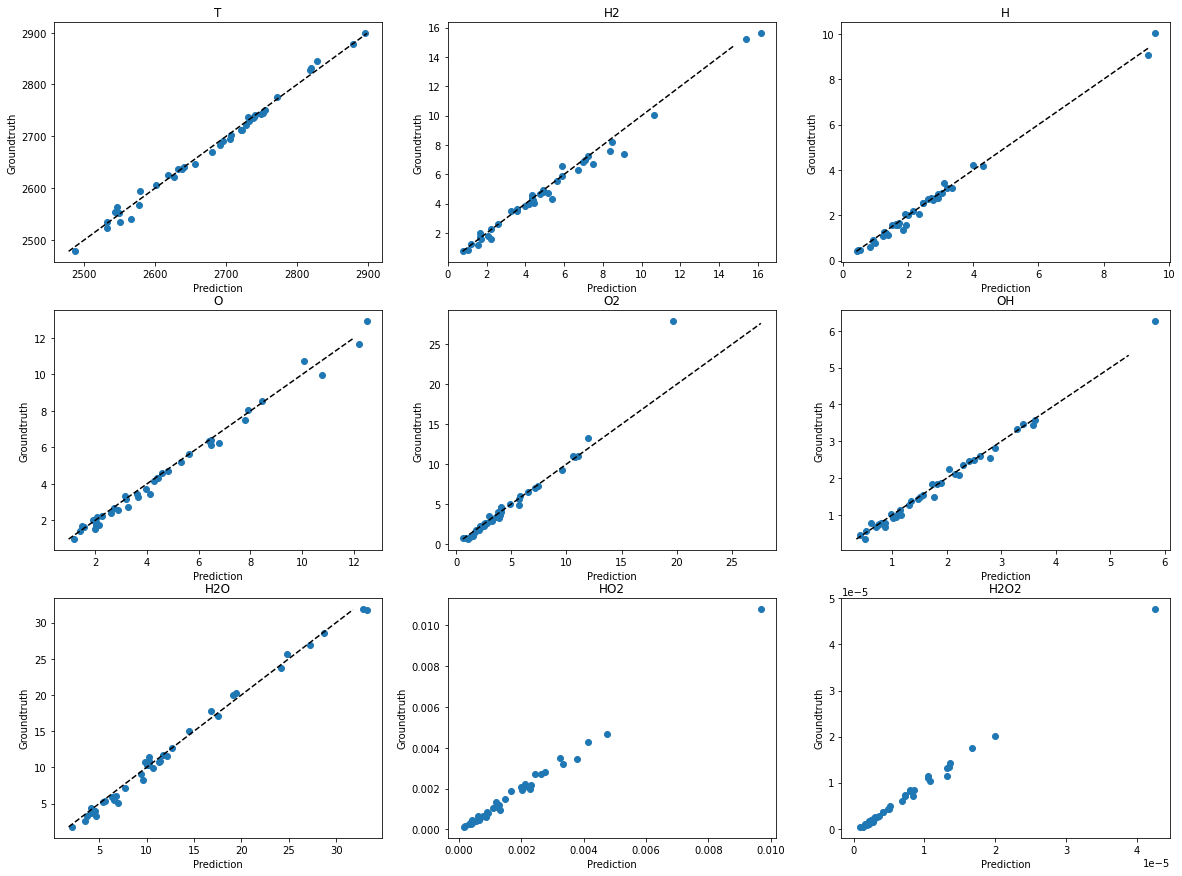

In [154]:
result_plot(torch.concat(output_stack).detach().squeeze(), torch.concat(predict_stack).detach().squeeze())

In [129]:
#test with last input from input.txt (row 197)
model.eval()
x_test = torch.tensor([[[0.345863,0.037831,0.074332,0.318219,0.061714,0.161887,4.7e-05,0.000106,290634.0,1684.0]]])#0.294903, 0.098913, 0.061895, 0.396953, 0.039459, 0.107669, 0.000127, 0.000081, 381430.000000, 2804.000000])
#standardize
x_test, _, _ = standardize(x_test, 0, train_x_mean, train_x_std)
pred_test = model(x_test)
pred_test = inverse_standardize(pred_test, 0, train_y_mean, train_y_std)
y_test = torch.from_numpy(np.loadtxt('/Volumes/GoogleDrive/My Drive/Skoltech/Research/Hydrogen Oxidation/Out_files_197/out4.txt', delimiter= ';')[-1, 1:-2])

In [130]:
torch.sum(torch.square(y_test - pred_test))/torch.sum(torch.square(y_test))

tensor(7.7634e-07, dtype=torch.float64, grad_fn=<DivBackward0>)

In [131]:
r2_score(y_test.flatten().detach().numpy(), pred_test.flatten().detach().numpy())

0.9999991249997051

In [132]:
# y_test.shape, pred_test.squeeze().shape
y_test, pred_test

(tensor([2.6285e+03, 2.5192e+00, 1.1115e+00, 2.8871e+00, 3.7093e+00, 1.1881e+00,
         7.9060e+00, 8.4763e-04, 3.2228e-06], dtype=torch.float64),
 tensor([[[2.6262e+03, 2.5668e+00, 1.1177e+00, 2.8354e+00, 3.6572e+00,
           1.1206e+00, 7.7661e+00, 8.1061e-04, 3.4853e-06]]],
        grad_fn=<AddBackward0>))

## Multiple time points

In [158]:
#initialize dataset object
batch_size = 32
ntimesteps = [0, 20, 50, 100, -1]
dataset = OxidationDataset(inputs_path = '/Volumes/GoogleDrive/My Drive/Skoltech/Research/Hydrogen Oxidation/input_197.txt',
                           outputs_dir = '/Volumes/GoogleDrive/My Drive/Skoltech/Research/Hydrogen Oxidation/Out_files_197', ntimesteps = ntimesteps)
# Creating Training and Validation loaders
dataset_size = len(dataset)
indices = list(range(dataset_size))
validation_split = 0.2
split = int(np.floor(validation_split * dataset_size))
shuffle_dataset = True
random_seed = 42
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

In [159]:
x,y = next(iter((train_loader))) #check number of features and targets
x.shape, y.shape

(torch.Size([32, 1, 10]), torch.Size([32, 5, 9]))

In [337]:
#model
class Base_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(Base_RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(self.input_size, self.hidden_size, self.num_layers, dropout = 0.1, batch_first = True)
        self.linear = nn.Linear(self.hidden_size, self.input_size)
        
    def forward(self, x, in_hidden = None):
        if in_hidden == None:
            out, out_hidden = self.rnn(x)
        else:
            out, out_hidden = self.rnn(x, in_hidden)
        out = self.linear(out)
        return out, out_hidden
    
class RNN_Model_Multiple(nn.Module):
    def __init__(self,input_size, hidden_size, num_layers, output_size, ntimesteps):
        super(RNN_Model_Multiple, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.ntimesteps = ntimesteps
        self.base_rnn = Base_RNN(self.input_size, self.hidden_size, self.num_layers, self.output_size)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(self.input_size, self.output_size)
        
    def forward(self, x, hidden = None):
        out = x
        #to store outputs
        outputs = []
        
        for t in range(self.ntimesteps):                
            #pass to rnn
            out, hidden = self.base_rnn(out, hidden)
            #pass to output layer
            outputs.append(self.linear(self.relu(out)))
            #skip connection
            out += x

        return torch.concat(outputs, 1), hidden

In [354]:
#initialize the model
input_size = 10
hidden_size = 32
num_layers = 2
output_size = 9
ntimesteps = 210
model = RNN_Model_Multiple(input_size, hidden_size, num_layers, output_size, ntimesteps)
model.apply(init_weights)
model

RNN_Model_Multiple(
  (base_rnn): Base_RNN(
    (rnn): RNN(10, 32, num_layers=2, batch_first=True, dropout=0.1)
    (linear): Linear(in_features=32, out_features=10, bias=True)
  )
  (relu): ReLU()
  (linear): Linear(in_features=10, out_features=9, bias=True)
)

In [355]:
out, hid = model(x.float())

In [356]:
hid.shape

torch.Size([2, 32, 32])

In [358]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

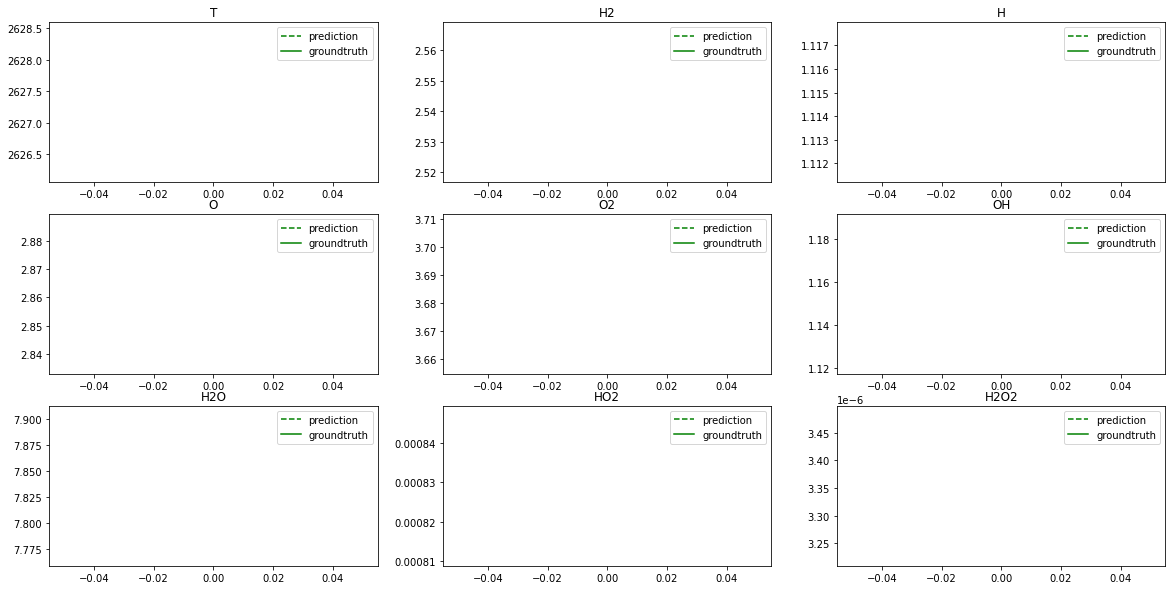

In [133]:
fig, ax = plt.subplots(3,3, figsize = (20,10))
labels = ['T', 'H2',	'H', 'O', 'O2',	'OH',	'H2O',	'HO2',	'H2O2']
for i in range(9):
    a,b = i//3, i%3
    A = pred_test.squeeze()[i]
    A_true = y_test[i]
    # ax[a,b].figure()
    ax[a,b].plot(A.detach().numpy(), '--g', label = 'prediction')
    ax[a,b].plot(A_true.detach().numpy(), '-g', label = 'groundtruth')
    ax[a,b].set_title(labels[i])
    ax[a,b].legend()
# plt.legend()
plt.show()

In [1044]:
#line 100 in input
x_test0 = torch.tensor([[0.532065,0.126334,0.106878,0.106594,0.034237,0.093657,0.000156,8e-05, 428284, 1618]])
pred_test0 = model(x_test0)
y_test0 = torch.from_numpy(np.loadtxt('Out_files/out99.txt', delimiter= ';')[:ntimesteps, 1:-2])

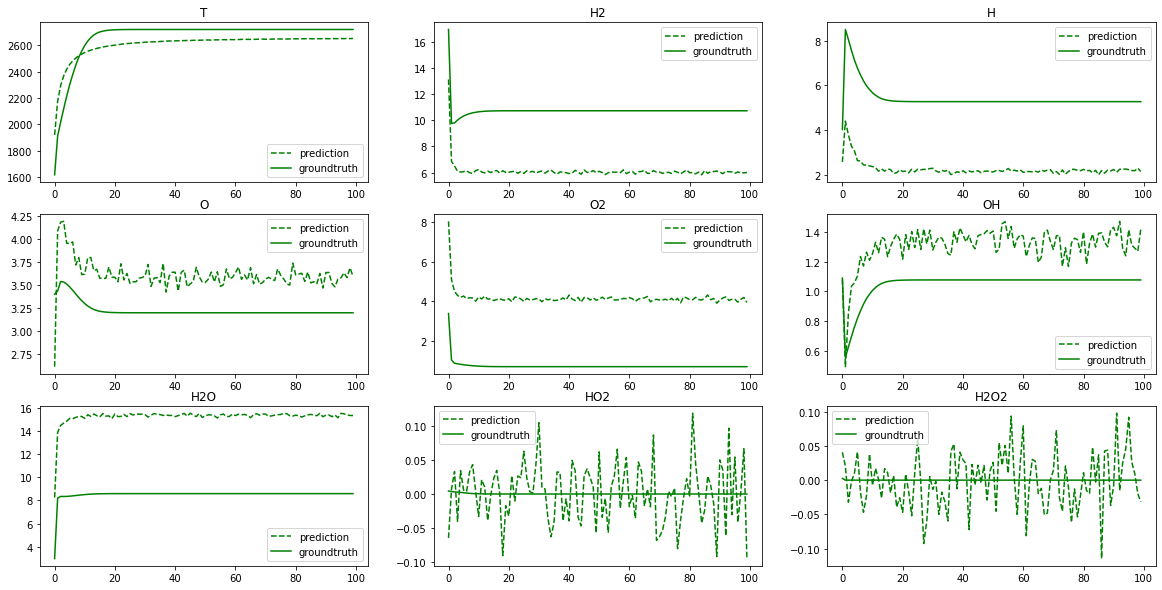

In [1045]:
fig, ax = plt.subplots(3,3, figsize = (20,10))
labels = ['T', 'H2',	'H', 'O', 'O2',	'OH',	'H2O',	'HO2',	'H2O2']
for i in range(9):
    a,b = i//3, i%3
    A = pred_test0[0,:,i]
    A_true = y_test0[:,i]
    # ax[a,b].figure()
    ax[a,b].plot(A.detach().numpy(), '--g', label = 'prediction')
    ax[a,b].plot(A_true.detach().numpy(), '-g', label = 'groundtruth')
    ax[a,b].set_title(labels[i])
    ax[a,b].legend()
# plt.legend()
plt.show()

In [1046]:
#test with last input from input.txt (row 197)
x_test1 = torch.tensor([[0.294903, 0.098913, 0.061895, 0.396953, 0.039459, 0.107669, 0.000127, 0.000081, 381430.000000, 2804.000000]])
model.eval()
pred_test1 = model(x_test1)
y_test1 = torch.from_numpy(np.loadtxt('Out_files/out196.txt', delimiter= ';')[:ntimesteps, 1:-2])

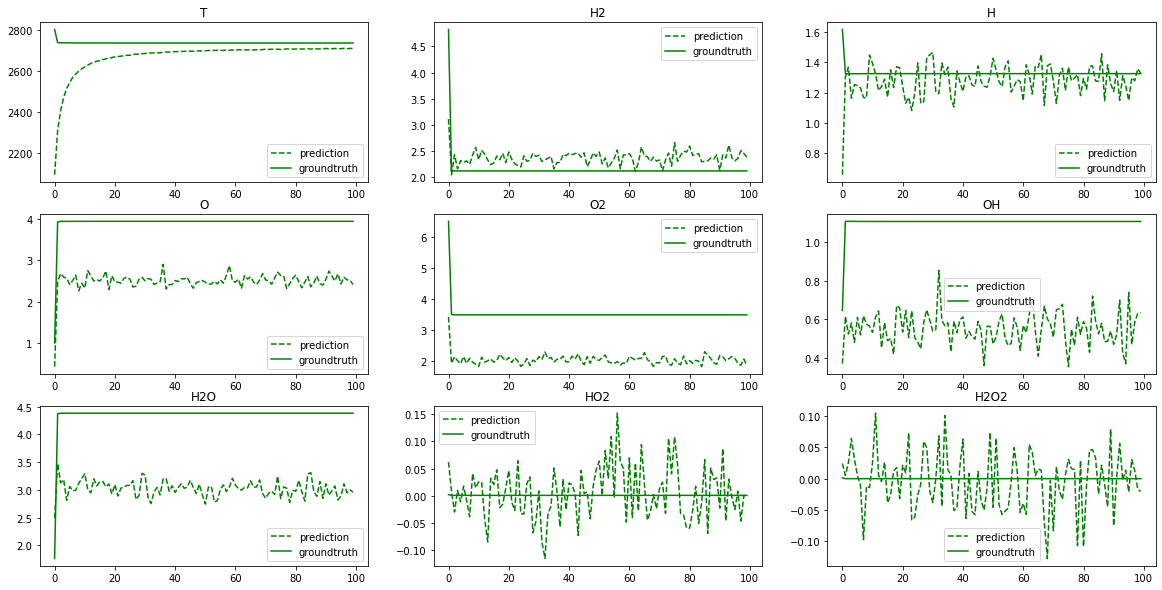

In [1047]:
fig, ax = plt.subplots(3,3, figsize = (20,10))
labels = ['T', 'H2',	'H', 'O', 'O2',	'OH',	'H2O',	'HO2',	'H2O2']
for i in range(9):
    a,b = i//3, i%3
    A = pred_test1[0,:,i]
    A_true = y_test1[:,i]
    # ax[a,b].figure()
    ax[a,b].plot(A.detach().numpy(), '--g', label = 'prediction')
    ax[a,b].plot(A_true.detach().numpy(), '-g', label = 'groundtruth')
    ax[a,b].set_title(labels[i])
    ax[a,b].legend()
# plt.legend()
plt.show()

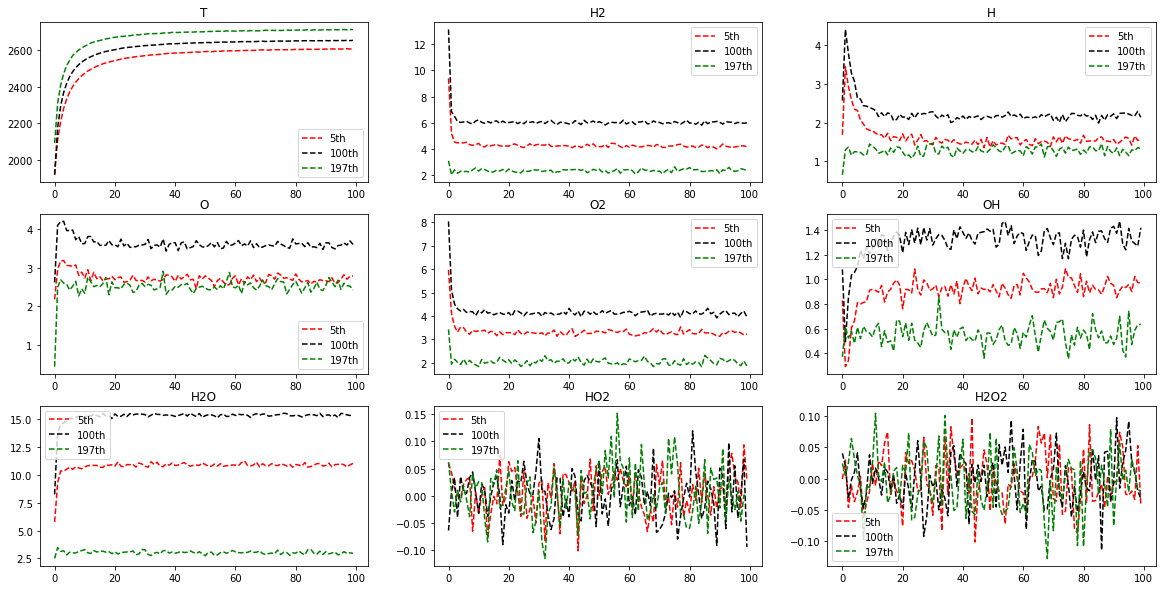

In [1048]:
fig, ax = plt.subplots(3,3, figsize = (20,10))
labels = ['T', 'H2',	'H', 'O', 'O2',	'OH',	'H2O',	'HO2',	'H2O2']
for i in range(9):
    a,b = i//3, i%3
    A = pred_test[0,:,i]
    B = pred_test0[0,:,i]
    C = pred_test1[0,:,i]
    # ax[a,b].figure()
    ax[a,b].plot(A.detach().numpy(), '--r', label = '5th')
    ax[a,b].plot(B.detach().numpy(), '--k', label = '100th')
    ax[a,b].plot(C.detach().numpy(), '--g', label = '197th')
    ax[a,b].set_title(labels[i])
    ax[a,b].legend()
# fig.title('Predictions')
plt.show()

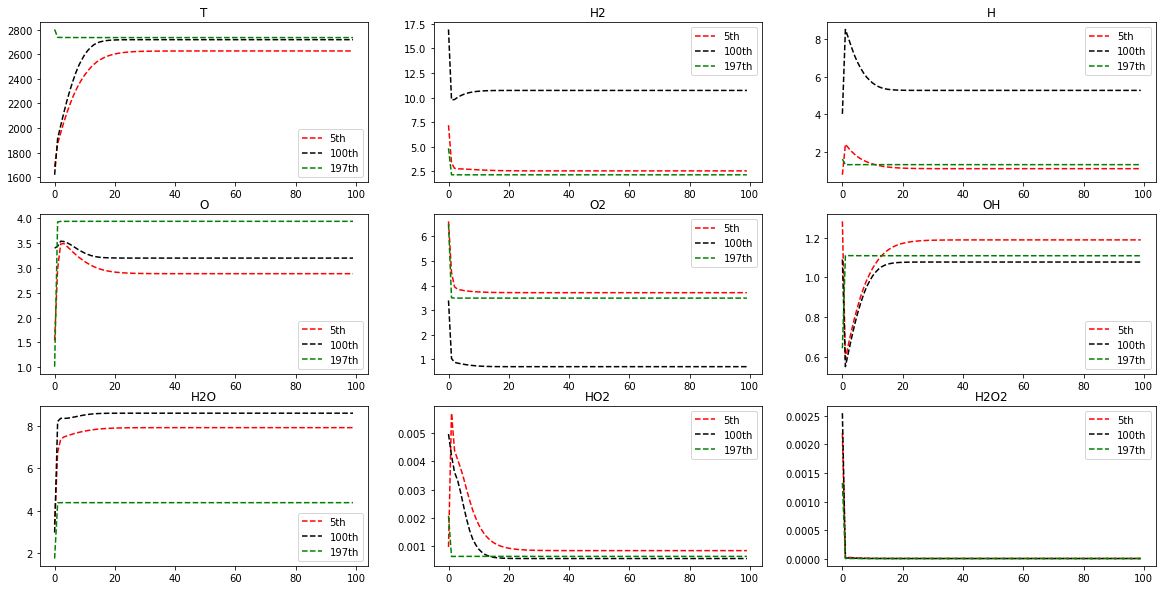

In [1049]:
fig, ax = plt.subplots(3,3, figsize = (20,10))
labels = ['T', 'H2',	'H', 'O', 'O2',	'OH',	'H2O',	'HO2',	'H2O2']
for i in range(9):
    a,b = i//3, i%3
    A = y_test[:,i]
    B = y_test0[:,i]
    C = y_test1[:,i]
    # ax[a,b].figure()
    ax[a,b].plot(A.detach().numpy(), '--r', label = '5th')
    ax[a,b].plot(B.detach().numpy(), '--k', label = '100th')
    ax[a,b].plot(C.detach().numpy(), '--g', label = '197th')
    ax[a,b].set_title(labels[i])
    ax[a,b].legend()
# fig.title('Predictions')
plt.show()

In [944]:
for i in range(3):
    m = model.layers[3*i].weight
    b = model.layers[3*i].bias
    print(f'====={3*i}======')
    print(m.mean().detach(), m.std().detach())
    print(b.mean().detach(), b.std().detach())

=====0======
tensor(0.0564) tensor(0.5724)
tensor(0.0147) tensor(0.1512)
=====3======
tensor(-0.0032) tensor(0.2153)
tensor(0.0298) tensor(0.1650)
=====6======
tensor(-0.0047) tensor(0.0848)
tensor(0.3122) tensor(0.2026)


In [529]:
y_test[4,]

tensor([2.7205e+00, 1.8806e+00, 3.4438e+00, 3.8198e+00, 7.9547e-01, 7.5150e+00,
        3.7687e-03, 1.5617e-05], dtype=torch.float64)

In [228]:
A

tensor([[1906.7864, 2241.5005, 2369.2798, 2448.4771, 2499.6350, 2528.8445,
         2541.1162, 2563.6965, 2573.1760, 2565.0425, 2584.6941, 2575.4705,
         2580.0020, 2584.3088, 2597.2722, 2599.5920, 2594.3867, 2597.4456,
         2599.5007, 2601.6626, 2603.7278, 2608.1594, 2609.2202, 2608.9348,
         2610.3811, 2611.5002, 2612.7886, 2613.7515, 2614.5532, 2616.0764,
         2616.9585, 2616.7957, 2617.4631, 2619.6982, 2620.4956, 2619.4236,
         2622.0005, 2622.7825, 2623.4954, 2621.6819, 2624.6724, 2622.7312,
         2623.1548, 2626.4128, 2625.1619, 2627.4705, 2628.0007, 2625.4243,
         2625.9709, 2626.1880, 2626.9294, 2626.9294, 2630.6655, 2627.7676,
         2631.7092, 2631.8899, 2632.2178, 2632.5156, 2632.8757, 2633.2319,
         2633.5786, 2633.8838, 2634.2378, 2630.6648, 2630.9602, 2635.1472,
         2635.5718, 2635.6909, 2635.9548, 2632.3521, 2636.3359, 2632.5796,
         2636.7942, 2637.1099, 2637.1838, 2633.1060, 2637.5439, 2637.7278,
         2633.5251, 2633.